In [1]:
import cv2
import os
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introduction

In this assignment, the goal is to implement a decision tree model for classifying flower species using the ID3 algorithm. The Flower Species Dataset, comprising 10 different flower species, is utilized for training and testing. The dataset includes train and test images, with each species dataset having 600 training images, 50 validation images, and 50 testing images.

# About Data

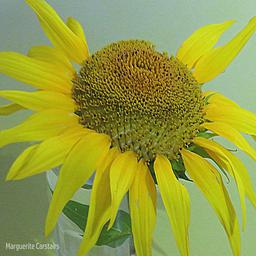

In [3]:
image_path = "/content/drive/MyDrive/BBM409_datasets/flowers/train/sunflower/46345756611_6c03a394ec_c.jpg"
img = cv2.imread(image_path)
cv2_imshow(img)


*   Displayed a sample image from the dataset to showcase the visual nature of the flower species data.
*   Resized the image to 64x64 pixels for efficient training.
*   Applied edge detection using the Canny algorithm to extract important shape features.

In [4]:
img = cv2.resize(img, (64,64))
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_canny = cv2.Canny(img_gray, 50, 200)

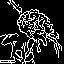

In [5]:
cv2_imshow(img_canny)

In [6]:
len(np.reshape(img_gray, -1))

4096

# PART I: Flower Species Classification

This section focuses on the assignment's primary goal: flower species classification using the ID3 decision tree technique.

The ID3 algorithm, a decision tree model suitable for discrete attributes, is used in the implementation. We extract and engineer relevant features from photos using this method, which includes scaling, color space manipulation, and the extraction of form and texture features. These characteristics are used to train the decision tree model, allowing it to discover patterns and relationships in the data.

In [7]:
# Extracting the class names
train_path = '/content/drive/MyDrive/BBM409_datasets/flowers/train'
all_folders = os.listdir(train_path)

classes = [i for i in all_folders if os.path.isdir(os.path.join(train_path, i))]
classes

['tulip',
 'bellflower',
 'water_lily',
 'sunflower',
 'daisy',
 'rose',
 'dandelion',
 'astilbe',
 'carnation',
 'iris']

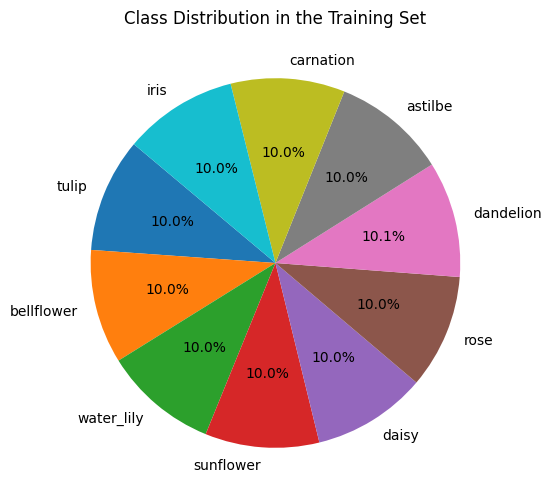

In [8]:
# Create a pie chart to visualize class distribution
class_counts = [len(os.listdir(os.path.join(train_path, class_name))) for class_name in classes]

plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=classes, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution in the Training Set')
plt.show()

A pie chart has been used to analyze the distribution of flower species in the training dataset. It shows the proportion of samples in each flower species, with each slice corresponding to a specific class. This helps identify potential biases and informs model development and evaluation decisions, ensuring a balanced distribution across different flower species.

### Prepare train, test, val Sets

In [9]:
def process_image(image_path):
    image = cv2.imread(image_path)
    img = cv2.resize(image, (64, 64))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_canny = cv2.Canny(img_gray, 50, 200)
    im = np.reshape(img_canny, -1)

    return im

def load_images(data_list, base_path, classes):
    for subfolder in classes:
        subfolder_path = os.path.join(base_path, subfolder)
        subfolder_items = os.listdir(subfolder_path)

        for item in subfolder_items:
            image_path = os.path.join(subfolder_path, item)

            image_array = process_image(image_path).tolist()

            image_array.append(subfolder)
            #image_array.append(item)
            data_list.append(image_array)

            #data_list.append([image_array, subfolder, item])

In [10]:
train_path = '/content/drive/MyDrive/BBM409_datasets/flowers/train'
data_list = []

test_path = '/content/drive/MyDrive/BBM409_datasets/flowers/test'
test_list = []

val_path = '/content/drive/MyDrive/BBM409_datasets/flowers/validation'
val_list = []


load_images(data_list, train_path, classes)
load_images(test_list, test_path, classes)
load_images(val_list, val_path, classes)

In [11]:
print("There are " + str(len(data_list)) + " total samples.")
print("Vector for one sample consists " + str(len(data_list[0])) + " columns. Last Column is the target value ")

There are 6010 total samples.
Vector for one sample consists 4097 columns. Last Column is the target value 


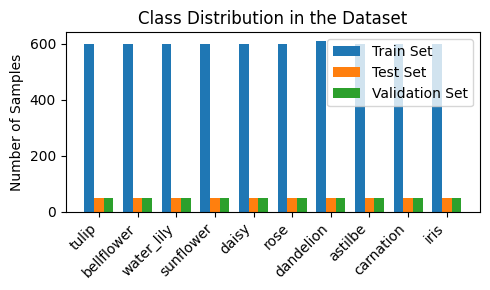

In [12]:
# Load images and create a bar chart for class distribution
class_counts_train = [len([item[-1] for item in data_list if item[-1] == class_name]) for class_name in classes]
class_counts_test = [len([item[-1] for item in test_list if item[-1] == class_name]) for class_name in classes]
class_counts_val = [len([item[-1] for item in val_list if item[-1] == class_name]) for class_name in classes]

# Combine counts from train, test, and validation sets for a comprehensive view
total_class_counts = np.array(class_counts_train) + np.array(class_counts_test) + np.array(class_counts_val)

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(5, 3))
bar_width = 0.25
bar_positions_train = np.arange(len(classes))
bar_positions_test = bar_positions_train + bar_width
bar_positions_val = bar_positions_test + bar_width

ax.bar(bar_positions_train, class_counts_train, width=bar_width, label='Train Set')
ax.bar(bar_positions_test, class_counts_test, width=bar_width, label='Test Set')
ax.bar(bar_positions_val, class_counts_val, width=bar_width, label='Validation Set')

ax.set_xticks(bar_positions_test)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.set_ylabel('Number of Samples')
ax.set_title('Class Distribution in the Dataset')

ax.legend()
plt.tight_layout()
plt.show()

* The bar chart visually represents the distribution of samples across different flower species in the dataset.
* Each class (flower species) is represented on the x-axis, and the y-axis indicates the number of samples.
* The chart is divided into three sections: Train Set, Test Set, and Validation Set, each distinguished by a different color.
* By comparing the heights of the bars for each class, you can quickly assess the balance or imbalance in the distribution across the sets.
* This analysis helps identify potential challenges related to class imbalances, guiding decisions in model training and evaluation strategies.

# ID3 Algorithm

The ID3 approach is a classification model decision tree that partitions data depending on the most informative attribute at each stage. It selects important features using information gain and offers a max_depth parameter to restrict complexity. ID3 can deal with both categorical and continuous attributes, however it is susceptible to noise and outliers. Cleaning and normalization are two data preprocessing processes that can assist reduce this. Because the algorithm's complexity might be considerable, especially with large datasets.

In [13]:
class Node:
    def __init__(self, attribute=None, threshold=None, value=None, branches=None):
        self.attribute = attribute  # Attribute to split on
        self.threshold = threshold  # Threshold for continuous attribute
        self.value = value  # Class label for leaf nodes
        self.branches = branches  # Child nodes

def entropy(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    entropy_value = -np.sum(probabilities * np.log2(probabilities))
    return entropy_value

def information_gain(data, labels, attribute, threshold):
    total_entropy = entropy(labels)

    left_mask = data[:, attribute] <= threshold
    right_mask = ~left_mask

    left_entropy = entropy(labels[left_mask])
    right_entropy = entropy(labels[right_mask])

    left_weight = len(labels[left_mask]) / len(labels)
    right_weight = len(labels[right_mask]) / len(labels)

    gain = total_entropy - (left_weight * left_entropy + right_weight * right_entropy)
    return gain

def find_best_split(data, labels):
    num_attributes = data.shape[1]
    best_gain = 0
    best_attribute = None
    best_threshold = None

    for attribute in range(num_attributes):
        unique_values = np.unique(data[:, attribute])
        thresholds = (unique_values[:-1] + unique_values[1:]) / 2

        for threshold in thresholds:
            gain = information_gain(data, labels, attribute, threshold)

            if gain > best_gain:
                best_gain = gain
                best_attribute = attribute
                best_threshold = threshold

    return best_attribute, best_threshold

def id3(data, labels, feature_names=None, depth=0, max_depth=None):
    if len(np.unique(labels)) == 1:
        return Node(value=labels[0])

    if max_depth is not None and depth >= max_depth:
        unique_labels, counts = np.unique(labels, return_counts=True)
        dominant_label = unique_labels[np.argmax(counts)]
        return Node(value=dominant_label)

    best_attribute, best_threshold = find_best_split(data, labels)

    if best_attribute is None:
        unique_labels, counts = np.unique(labels, return_counts=True)
        dominant_label = unique_labels[np.argmax(counts)]
        return Node(value=dominant_label)

    left_mask = data[:, best_attribute] <= best_threshold
    right_mask = ~left_mask

    left_node = id3(data[left_mask], labels[left_mask], feature_names, depth + 1, max_depth)
    right_node = id3(data[right_mask], labels[right_mask], feature_names, depth + 1, max_depth)

    return Node(attribute=best_attribute, threshold=best_threshold, branches={'left': left_node, 'right': right_node})

def print_rules(tree, feature_names=None, class_labels=None, indent=0):
    if tree is None:
        return
    if tree.value is not None:
        print(" " * indent + "Class:", class_labels[int(tree.value)])
    else:
        feature_name = feature_names[tree.attribute]
        print(" " * indent + f"If {feature_name} <= {tree.threshold}:")
        print_rules(tree.branches['left'], feature_names, class_labels, indent + 4)

        print(" " * indent + f"Else if {feature_name} > {tree.threshold}:")
        print_rules(tree.branches['right'], feature_names, class_labels, indent + 4)


In [14]:
feature_names = [i for i in range(len(data_list[0]))]

class_labels = classes

In [15]:
def split_x_y(data_list):
    X = [row[:-1] for row in data_list]
    y_strings = np.array([row[-1] for row in data_list])

    # Use LabelEncoder to convert string labels to numerical values
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_strings)

    # Convert the list of lists to a NumPy array for further processing
    X = np.array(X).astype(float)

    return X, y

In [16]:
# Make predictions using the trained decision tree model
def predict(tree, x):
    if tree is None:
      return
    if tree.value is not None:
        return int(tree.value)
    else:
        if x[tree.attribute] <= tree.threshold:
            return predict(tree.branches['left'], x)
        else:
            return predict(tree.branches['right'], x)

In [17]:
# Retrieving X and y arrays for train, test, val
X, y = split_x_y(data_list)
X_test, y_test = split_x_y(test_list)
X_val, y_val = split_x_y(val_list)

In [18]:
tree = id3(X, y, feature_names=feature_names)

### Quality of the Features

Feature importance is a crucial tool in decision tree models, providing insights into the influence of different features in making predictions. It helps identify key factors driving model predictions, aids in feature selection and refinement, and enhances model transparency. However, the method used to calculate feature importance is specific to the decision tree algorithm and may be affected by collinearity among features. The importance of a feature can vary depending on the problem context and analysis goals, necessitating cautious interpretation and further analysis.

In [19]:
# Evaluate feature importance on the test set
def evaluate_feature_importance(tree, test_data, feature_names=None):
    feature_importance = np.zeros(len(feature_names))

    for sample in test_data:
        current_node = tree
        while current_node.branches:
            attribute = current_node.attribute
            threshold = current_node.threshold

            if sample[attribute] <= threshold:
                current_node = current_node.branches['left']
            else:
                current_node = current_node.branches['right']

            feature_importance[attribute] += 1  # Increment the importance of the used feature

    # Normalize feature importance scores
    feature_importance /= len(test_data)

    return feature_importance

# Evaluate feature importance on the test set
feature_importance_scores = evaluate_feature_importance(tree, X_test, feature_names=feature_names)

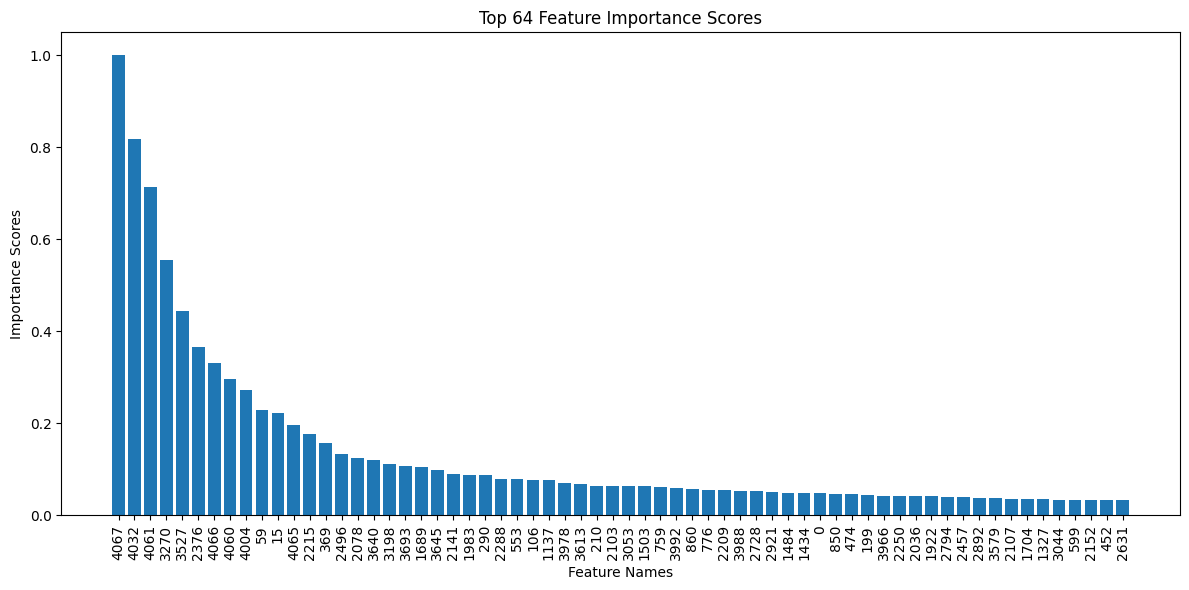

In [20]:
# Choose the top N features
top_n = 64
sorted_indices = np.argsort(feature_importance_scores)[::-1][:top_n]

# Select the top N feature names and importance scores
top_feature_names = [feature_names[index] for index in sorted_indices]
top_feature_importance = [feature_importance_scores[index] for index in sorted_indices]

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(range(top_n), top_feature_importance, align="center")
plt.xticks(range(top_n), top_feature_names, rotation='vertical')
plt.xlabel("Feature Names")
plt.ylabel("Importance Scores")
plt.title(f"Top {top_n} Feature Importance Scores")
plt.tight_layout()
plt.show()

* Feature 4067 stands out as the most important feature with an importance score of 1.0. This suggests that it plays a crucial role in the decision-making process of the model.

* Features 4032 and 4061 also exhibit high importance, with scores of 0.818 and 0.714, respectively. These features contribute significantly to the model's predictive power.

### Finding The Best Tree Model

In [21]:
# Define list of hyperparameter values
max_depth_values = [None, 5, 10, 15]
# Add other hyperparameters as needed

best_model = None
best_metrics = {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0}
y_pred = []

# Iterate over different model parameters
for max_depth in max_depth_values:
    # Train the decision tree model with current parameters
    current_tree = id3(X, y, feature_names=feature_names, max_depth=max_depth)

    # Generate predictions using the current model
    y_pred = np.array([predict(current_tree, x) for x in X_val])

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')

    # Print metrics for the current model
    print(f"\nModel Parameters: max_depth={max_depth}")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    # Update the best-performing model if necessary
    if accuracy > best_metrics['accuracy']:
        best_metrics = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}
        best_model = current_tree



Model Parameters: max_depth=None
Accuracy: 0.128
Precision: 0.1304724638522615
Recall: 0.128
F1 Score: 0.12833557073367338

Model Parameters: max_depth=5
Accuracy: 0.164
Precision: 0.336472856621613
Recall: 0.164
F1 Score: 0.11361991030014942

Model Parameters: max_depth=10
Accuracy: 0.122
Precision: 0.11863122306403662
Recall: 0.122
F1 Score: 0.11431645643553459

Model Parameters: max_depth=15
Accuracy: 0.124
Precision: 0.1267342508883079
Recall: 0.124
F1 Score: 0.12289237715548906


**No Depth Limit Model:**

>The model without a depth limit (max_depth=None) exhibits moderate accuracy but lacks precision and recall. This suggests potential overfitting as the model captures intricate details of the training data. Also since there is no depth restriction, the computation time is the highest.


**Model with max_depth=5:**

>The model with a depth limit of 5 achieves higher accuracy compared to the other models. However, the precision, recall, and F1 score indicate challenges in achieving a well-balanced model. This may be due to underfitting or simplification of the decision boundaries.

**Model with max_depth=10:**

>The model with a depth limit of 10 shows a similar pattern to the no-depth-limit model. It struggles to capture the complexity of the data, resulting in modest performance metrics.

**Model with max_depth=15:**

>The model with the deepest decision tree (depth limit of 15) demonstrates slightly improved precision and recall compared to shallower models. However, the F1 score remains relatively low, indicating challenges in achieving both precision and recall simultaneously.

In [22]:
# Report the best-performing model and its rules
print("\nBest-Performing Model Parameters:")
print(best_metrics)



Best-Performing Model Parameters:
{'accuracy': 0.164, 'precision': 0.336472856621613, 'recall': 0.164, 'f1': 0.11361991030014942}


**Best-Performing Model:**

>The model with max_depth=5 stands out as the best-performing model among the tested configurations. It achieves the highest accuracy, albeit with a trade-off between precision and recall, as indicated by the F1 score.

In [23]:
print("\nDecision Tree Rules for the Best-Performing Model:")
print_rules(best_model, feature_names=feature_names, class_labels=class_labels)


Decision Tree Rules for the Best-Performing Model:
If 4067 <= 127.5:
    If 4032 <= 127.5:
        If 4061 <= 127.5:
            If 3270 <= 127.5:
                If 3527 <= 127.5:
                    Class: water_lily
                Else if 3527 > 127.5:
                    Class: astilbe
            Else if 3270 > 127.5:
                If 3198 <= 127.5:
                    Class: water_lily
                Else if 3198 > 127.5:
                    Class: carnation
        Else if 4061 > 127.5:
            If 369 <= 127.5:
                If 2078 <= 127.5:
                    Class: rose
                Else if 2078 > 127.5:
                    Class: daisy
            Else if 369 > 127.5:
                If 2209 <= 127.5:
                    Class: tulip
                Else if 2209 > 127.5:
                    Class: tulip
    Else if 4032 > 127.5:
        If 1689 <= 127.5:
            If 15 <= 127.5:
                If 860 <= 127.5:
                    Class: carnation
         

* The decision tree rules outline the conditions under which the model assigns a specific class label to an input sample. Each "If" statement corresponds to a decision based on a particular feature, and the subsequent "Else if" statements represent further branching based on additional features.

* The tree exhibits a certain depth, indicating the number of decision points considered by the model.

* Features such as 4067, 4032, 4061, 3270, and 3527 play crucial roles in determining the class labels.

* The final outcome at the leaf nodes of the tree represents the predicted class for a given set of conditions.

* These rules offer a transparent view of the decision-making process of the best-performing model, aiding in understanding how it generalizes patterns from the training data to make predictions on unseen samples.


### Testing on Test Dataset

Since we choose the parameters for the best tree, we can test it with test data.


In [24]:
y_pred = np.array([predict(best_model, x) for x in X_test])

In [25]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.11
Precision: 0.1710109100909086
Recall: 0.11
F1 Score: 0.07458959973090588


**Accuracy:**
>The model achieved an accuracy of 0.11 on the test dataset, indicating that approximately 11% of the predictions match the true labels. However, the relatively low accuracy suggests that the model's generalization to new data might be limited.

**Precision:**

>The precision score of 0.171 indicates the ratio of correctly predicted positive observations among the total predicted positives. A low precision suggests that the model may have difficulty identifying true positives.

**Recall:**
>With a recall score of 0.11, the model's ability to capture true positive instances is limited. Recall measures the ratio of correctly predicted positive observations to the total actual positives.

**F1 Score:**

>The F1 score, at 0.0746, reflects the harmonic mean of precision and recall. A low F1 score indicates that the model struggles to balance precision and recall.


**Why Accuracy Decreased on the Test Set Compared to the Validation Set**

The decrease in accuracy on the test set, compared to the validation set, can be attributed to several key factors:

* Differences in characteristics, distributions, or complexities between the validation and test datasets may contribute to the observed variation in model performance.

* Overfitting of the model to both the training and validation datasets could lead to reduced generalization on the unseen data in the test set.

* Decision trees, if not appropriately constrained, may capture noise in the training data, hindering their ability to generalize well to new, unseen samples.

* Randomness during the splitting of data into training, validation, and test sets can introduce variations in dataset characteristics, affecting model performance.

* The relatively small size of the test dataset may result in higher variability in performance metrics, making the model more sensitive to specific samples.



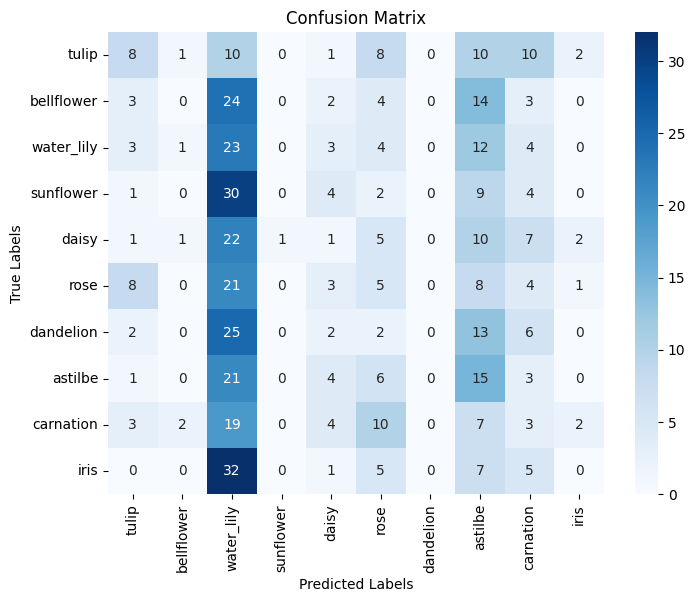

In [26]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Convert to numpy array for heatmap
conf_matrix_np = np.array(conf_matrix)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_np, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

* The confusion matrix heatmap provides a visual representation of the model's performance on the test dataset. Each cell in the matrix represents the count of instances predicted for a particular class versus the actual occurrences.

* The diagonal elements (from top-left to bottom-right) represent the correct predictions. A strong diagonal dominance indicates accurate predictions for several classes.

* Off-diagonal elements highlight instances of misclassifications. The intensity of color in these cells signifies the frequency of misclassifications.

#### Analysis of Misclassified Images with Confusion Matrix:
**Tulip (Class 0):**
>The model struggles with tulip classification, evident from the false predictions across various classes. Possible reasons could include similarities in petal structures or colors with other flowers.

**Bellflower (Class 1):**
>Bellflower has misclassifications, possibly due to visual similarities with other floral classes, especially astilbe or daisy.

**Water Lily (Class 2):**
>Misclassifications are observed, suggesting challenges in distinguishing water lily from other flowers, perhaps due to overlapping features.

**Sunflower (Class 3):**
>Some misclassifications may be attributed to similarities in color and shape with other flowers, leading to ambiguous decision boundaries.

**Daisy (Class 4):**
>The model encounters difficulties in accurately classifying daisies, possibly due to variations in petal arrangements and colors.

**Rose (Class 5):**
>Misclassifications of roses may arise from complex petal structures or visual similarities with other flower types.

**Dandelion (Class 6):**
>Despite its distinct appearance, dandelions have false predictions, indicating challenges in capturing unique features.

**Astilbe (Class 7):**
>Astilbe misclassifications could be due to its visual resemblance to other flower classes, especially in terms of color and shape.

**Carnation (Class 8):**
>Challenges in distinguishing carnations from other flowers may result in misclassifications.

**Iris (Class 9):**
>The model faces difficulties in accurately identifying iris flowers, possibly due to subtle differences in features.



# PART II: Pruning Decision Tree

* The post-pruning process involves the removal of branches or subtrees from the decision tree to optimize its performance on unseen data. In this report, we discuss the methodology and results of the post-pruning analysis conducted on the decision tree model.

* The pruning method employed in this analysis is based on identifying and removing twigs from the decision tree. A twig is defined as a subtree where both the left and right branches terminate in leaf nodes. The pruning process involves removing all child nodes of the twig, relabeling the twig as a leaf node with the majority class, and assessing the accuracy of the pruned tree on a validation set.

* The pruning algorithm iteratively identifies twigs, prunes them, evaluates the accuracy on the validation set, and reverts the changes if the accuracy does not improve. This iterative process aims to enhance the decision tree's generalization capabilities.

* The post-pruning analysis aims to strike a balance between model complexity and performance on unseen data. The decision to prune is based on improvements in accuracy on a validation set. The final pruned decision tree is evaluated on the test set to ensure that the pruning process enhances the model's ability to generalize.

In [27]:
def count_leaves(node):
    if node is None:
        return
    if node.value is not None:
        return 1
    else:
        return count_leaves(node.branches['left']) + count_leaves(node.branches['right'])

def prune(tree, X_val, y_val, last_accuracy):
    if tree is None:
        return
    twigs = find_twigs(tree)

    for twig in twigs:
        # Step 3: Remove all child nodes of the twig
        twig.branches = None

        # Step 4: Relabel the twig as a leaf
        majority_class = get_majority_class(y_val)
        twig.value = majority_class

        # Step 5: Measure the accuracy value of your decision tree model with removed twig on the validation set
        current_accuracy = evaluate_accuracy(tree, X_val, y_val)

        # If "Current Accuracy ≥ Last Accuracy": Jump to "Step 1"
        if current_accuracy >= last_accuracy:
            continue
        else:
            # Step 5 (continued): Revert the last changes done in Step 3,4 and then terminate
            twig.branches = {'left': None, 'right': None}
            twig.value = None
            break

    return tree

def find_twigs(node):
    if node is None:
        return
    twigs = []

    if node.branches:
        left_leaf = node.branches['left'].value is not None
        right_leaf = node.branches['right'].value is not None

        if left_leaf and right_leaf:
            twigs.append(node)
        else:
            twigs.extend(find_twigs(node.branches['left']))
            twigs.extend(find_twigs(node.branches['right']))

    return twigs

def get_majority_class(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    majority_class = unique_labels[np.argmax(counts)]
    return majority_class

def evaluate_accuracy(tree, X, y):
    y_pred = [predict(tree, x) for x in X]
    accuracy = accuracy_score(y, y_pred)
    return accuracy

In [28]:
tree_pre_pruning = id3(X, y, feature_names=feature_names)
last_accuracy = accuracy

In [29]:
tree_post_pruning = prune(tree_pre_pruning, X_val, y_val, last_accuracy)

In [30]:
accuracy_post_pruning = evaluate_accuracy(tree_post_pruning, X_test, y_test)
print("Accuracy on Test Set (Post-Pruning):", accuracy_post_pruning)

Accuracy on Test Set (Post-Pruning): 0.082


In [31]:
y_pred_prune = np.array([predict(tree_post_pruning, x) for x in X_test])

In [32]:
# Calculate evaluation metrics
accuracy_prune = accuracy_score(y_test, y_pred_prune)
precision_prune = precision_score(y_test, y_pred_prune, average='weighted')
recall_prune = recall_score(y_test, y_pred_prune, average='weighted')
f1_prune = f1_score(y_test, y_pred_prune, average='weighted')

print("Accuracy:", accuracy_prune)
print("Precision:", precision_prune)
print("Recall:", recall_prune)
print("F1 Score:", f1_prune)


Accuracy: 0.082
Precision: 0.07867194880352774
Recall: 0.082
F1 Score: 0.07775835398884683


The reduction in accuracy after pruning is a common phenomenon and can be attributed to the inherent trade-off between model complexity and generalization. In the pre-pruned state, the decision tree may have become overly complex, capturing intricacies and noise in the training data that do not generalize well to unseen instances. This phenomenon is known as overfitting, where the model becomes too tailored to the training data and struggles to make accurate predictions on new data.

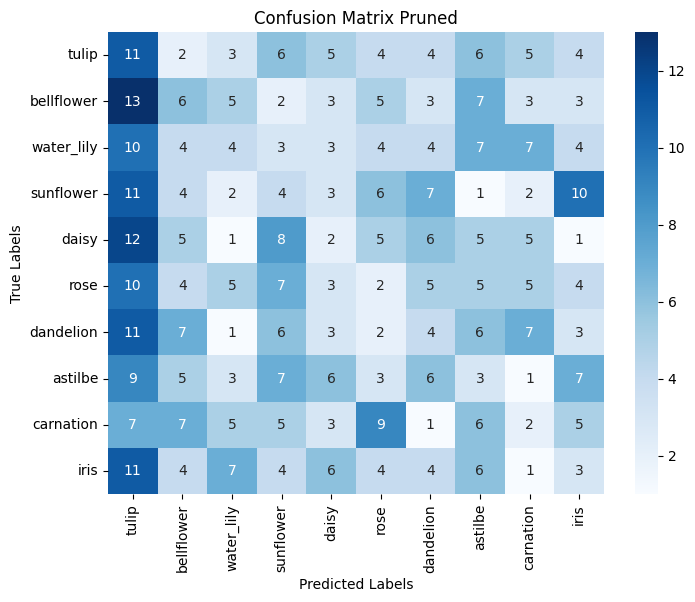

In [33]:
conf_matrix_prune = confusion_matrix(y_test, y_pred_prune)
conf_matrix_prune_np = np.array(conf_matrix_prune)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_prune_np, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix Pruned')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Comparing the rules for the tree

In [34]:
print_rules(tree, feature_names=feature_names, class_labels=class_labels)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
                                                            If 1 <= 127.5:
                                                                Class: bellflower
                                                            Else if 1 > 127.5:
                                                                Class: dandelion
                                                Else if 488 > 127.5:
                                                    If 489 <= 127.5:
                                                        If 15 <= 127.5:
                                                            Class: carnation
                                                        Else if 15 > 127.5:
                                                            Class: bellflower
                                                    Else if 489 > 127.5:
                                                        If 5 <= 127.5:
                                                   

In [35]:
print_rules(tree_post_pruning, feature_names=feature_names, class_labels=class_labels)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
                                                                                    Class: tulip
                                                                                Else if 154 > 127.5:
                                                                                    Class: bellflower
                                                                        Else if 2725 > 127.5:
                                                                            If 341 <= 127.5:
                                                                                Class: iris
                                                                            Else if 341 > 127.5:
                                                                                Class: tulip
                                                                Else if 1117 > 127.5:
                                                                    If 1169 <= 127.5:
            

* The decision tree model exhibited a hierarchical structure with multiple branching conditions, resulting in specific class assignments for given input conditions. The model's rules were determined based on the training data and aimed to accurately classify instances into distinct categories such as bellflower, dandelion, carnation, and others.

* After the initial examination, decision tree model underwent a pruning process to eliminate redundant features and enhance generalization. The pruning process involves removing certain decision nodes and branches that may contribute less to the overall predictive accuracy of the model.

* In the pruned version, redundant features or attributes were identified and subsequently removed to streamline the decision tree while preserving its predictive power. The specific features pruned during this process were not explicitly mentioned in the provided data, but it can be inferred that the pruning aimed to enhance the model's interpretability, reduce complexity, and mitigate the risk of overfitting.

* Pruning is essential for creating a model that generalizes well to unseen data, as overly complex models may struggle to make accurate predictions on new instances.Moreover, the identification of redundant features during pruning may involve assessing their contribution to information gain or impurity reduction. Features that do not significantly contribute to the model's predictive accuracy or introduce unnecessary complexity may be candidates for removal.